In [ ]:
# sequence length of 512 and applied padding and truncation to adjust inputs as needed.
# learning rate of .00001
# an Adam optimizer
# a dropout 0.3
# ran the model for 10 epochs using a batch size of 32.

In [ ]:
input_model = "bert"

In [ ]:
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.63 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.3 MB/s eta 0:00:00
 

In [ ]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig, TFRobertaForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

from transformers import logging
logging.set_verbosity_error()

import matplotlib.pyplot as plt
import seaborn as sns


import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [ ]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 512 #800

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512

# Max embeddings in BERT
BERT_MAX_EMBEDDINGS = 512 #1024
ROBERTA_MAX_EMBEDDINGS = 512 #1024
DISTILBERT_MAX_EMBEDDINGS = 512 #1024

# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/'

In [ ]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.1.4
sklearn version: 1.3.2


In [ ]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [ ]:
rdt_trainfile = f'{BASE_PATH}/Reddit/posts_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/posts_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/posts_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

In [ ]:
rdt_train

,ID,post,class_name,class_id
0,691324c4-5c30-44e0-b9e4-45b4f0715e21,i was making questions for my students and i r...,none,5
1,d4295391-9ca5-4398-b7c8-687e4a984ef1,i've recently requested testing accommodations...,adhd,0
2,58937fa5-3c2c-426b-8255-5a140fbab675,**cambodia** * koh rong: amazing beaches and a...,none,5
3,7daf364c-3b33-4cbe-be37-a214edf9a73e,synesthesia. what is synesthesia? according to...,none,5
4,22518271-4bb4-4caf-b683-7305da519288,i’m phil baran and i teach organic chemistry a...,none,5
...,...,...,...,...
13722,386a4117-0324-4b25-8330-b1a6857ccaa6,"i don't often succeed and when i do, it's like...",bipolar,2
13723,4dd92d63-1231-410d-b049-5d8c430c2f36,fuck i hate this question. fuck off. i got hom...,depression,3
13724,dbde1d3e-e527-4cf8-8045-2093aec2a784,hi. i'm not a native speaker and not a good en...,none,5
13725,5355fad6-5bb4-4092-8428-9b8527a6d261,i'm sorry to be such a downer all the time. i ...,bipolar,2


In [ ]:
rdt_test

,ID,post,class_name,class_id
0,b07b978c-7760-4932-85cb-5797b5e74168,most people able to be productive and function...,adhd,0
1,b2868fd2-e885-400e-b780-446c9581b1f1,i'm 23f and recently quit my job as a features...,adhd,0
2,3191b3b1-d355-41b6-9588-caeb3e169c9b,i just got finished with an interview and as t...,adhd,0
3,a3d60895-ef7c-4b57-b5be-632c9fd62150,off course i’ve forgotten what i exactly read....,adhd,0
4,66fae18e-e744-495f-b7a0-b985543f5052,"i have six siblings, and at least 4 of us have...",adhd,0
...,...,...,...,...
1483,5855d35b-bf7d-4a49-8030-b185f430f05a,i quit my job early this year and moved back t...,none,5
1484,a2faea38-8b93-43da-a75b-cb7c0ba1ae0d,there are lots of trolls trying to create a di...,none,5
1485,7ad72b7f-eba4-4c17-90b0-1038dc144a8b,&amp;#x200b; rawg is the largest video game da...,none,5
1486,e73c198f-5e8e-4c84-aedf-333b576f9939,hi reddit! i’m [dr. john m. and i serve as ceo...,none,5


In [ ]:
rdt_val

,ID,post,class_name,class_id
0,0b578b02-9a92-4093-8280-3a0f897f5c21,does anybody else struggle with this? i often ...,adhd,0
1,76f42c19-f4e5-4573-b32e-26a73b895ae5,ask questions to a teacher or other individual...,anxiety,1
2,1f3cf1f9-167a-4542-9b40-5a194c4e4856,6 years ago i swore i would never even conside...,bipolar,2
3,f45098bf-31bb-4853-9988-0bca15300d6a,does anyone else wear headphones in public wit...,anxiety,1
4,917b7fe0-6cde-4eff-afbe-890f1d4ec97a,i think the world is beautiful. there are so m...,depression,3
...,...,...,...,...
1711,7fd4fb23-9e12-4d77-a743-d7095c8d8c72,"sometimes when i am in a conversation, i have ...",adhd,0
1712,412b4fcc-4fdd-494b-b504-f4e8a7a8de94,i wanted to do this thing and be proud of it e...,anxiety,1
1713,1e77f1ea-b8ed-44f5-8390-b22faf4e555d,dae feel the constant need to explain yourself...,anxiety,1
1714,f2a8c251-2f9e-4d39-a820-c97ad1bc887e,when [can't feel my was released a few years a...,none,5


In [ ]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = f'{BASE_PATH}/Reddit/posts_train.csv'
rdt_tesstfile = f'{BASE_PATH}/Reddit/posts_test.csv'
rdt_valfile = f'{BASE_PATH}/Reddit/posts_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)
rdt_val = rdt_val.sample(frac=1).reset_index(drop=True)


# Split data into test and train
#train_size = int(0.8 * len(rdt_train))
train_size = int(len(rdt_train))
X_train = rdt_train.post
X_val = rdt_val.post
X_test = rdt_test.post
y_train = rdt_train.class_id
y_val = rdt_val.class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [ ]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['adhd' 'bipolar' 'anxiety' 'none' 'depression' 'ptsd']


array([0, 2, 1, 5, 3, 4])

In [ ]:
print(rdt_test.class_name.unique())
rdt_test.class_id.unique()

['none' 'anxiety' 'depression' 'adhd' 'ptsd' 'bipolar']


array([5, 1, 3, 0, 4, 2])

In [ ]:
print(rdt_val.class_name.unique())
rdt_val.class_id.unique()

['none' 'adhd' 'bipolar' 'depression' 'anxiety' 'ptsd']


array([5, 0, 2, 3, 1, 4])

In [ ]:
rdt_train

,ID,post,class_name,class_id
0,1f2d2706-baf9-41b2-bdb8-ab621a47864c,i have so much to get done tomorrow and i told...,adhd,0
1,09e567ac-8e4e-43de-afac-8c78e1c94bfd,"i’ve worked 25 days in a row between jobs, a f...",bipolar,2
2,1163f0ec-eeff-4bb0-a7a6-901b23ea00db,"like the title suggests, if i ever find myself...",anxiety,1
3,bb5a26aa-0827-473d-a45c-43e7463f552c,i've been having a very hard week for a number...,anxiety,1
4,9f42c49f-c025-49e7-99d8-8748cc2f8e6d,house democrats issued a subpoena on thursday ...,none,5
...,...,...,...,...
13722,b01c0f9a-6f1f-4cb6-bc7b-49052aae5c5d,i made a video to talk about language acquisit...,none,5
13723,18fc6f5c-e86a-4c5a-b9b7-788dde82e847,[twin studies: genetics may explain adult adhd...,adhd,0
13724,d1d373ec-35fa-4cad-ac3e-10279da473b4,"for those who are unaware, the band great whit...",none,5
13725,9f6576ce-dfaa-4522-8527-64f18125cf44,"i got a new job, the bosses really like me and...",ptsd,4


In [ ]:
test_examples[30]

'i don’t want to take meds particularly. i’m kinda anti meds. i’ve been on max dose for 3 years. worried it’ll be the end of me. or at least it could severely disable me. i don’t fee of life span while on meds and how they’re not really meant for long term use. i fear the worst. is anyone else here on meds for life more than likely? and how do you feel about it?'

In [ ]:
test_labels[30]

2

In [ ]:
val_examples[30]

"i don't have a lot of people to celebrate this milestone with, but i knew y'all would understand the significance. i'm anxious af, but also excited. i think this is going to be good."

In [ ]:
val_labels[30]

1

In [ ]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

# print(f'Distribution of the length of all title')
# print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Validation set labels shape: (1716,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Validation set examples shape: (1716,)
Test set examples shape: (1488,)
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


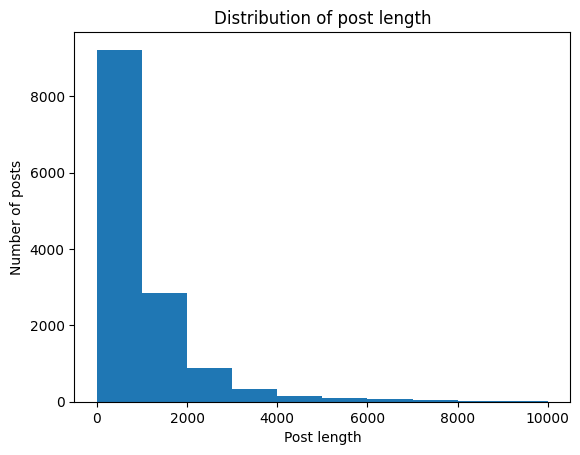

In [ ]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [ ]:
rdt_train

,ID,post,class_name,class_id
0,1f2d2706-baf9-41b2-bdb8-ab621a47864c,i have so much to get done tomorrow and i told...,adhd,0
1,09e567ac-8e4e-43de-afac-8c78e1c94bfd,"i’ve worked 25 days in a row between jobs, a f...",bipolar,2
2,1163f0ec-eeff-4bb0-a7a6-901b23ea00db,"like the title suggests, if i ever find myself...",anxiety,1
3,bb5a26aa-0827-473d-a45c-43e7463f552c,i've been having a very hard week for a number...,anxiety,1
4,9f42c49f-c025-49e7-99d8-8748cc2f8e6d,house democrats issued a subpoena on thursday ...,none,5
...,...,...,...,...
13722,b01c0f9a-6f1f-4cb6-bc7b-49052aae5c5d,i made a video to talk about language acquisit...,none,5
13723,18fc6f5c-e86a-4c5a-b9b7-788dde82e847,[twin studies: genetics may explain adult adhd...,adhd,0
13724,d1d373ec-35fa-4cad-ac3e-10279da473b4,"for those who are unaware, the band great whit...",none,5
13725,9f6576ce-dfaa-4522-8527-64f18125cf44,"i got a new job, the bosses really like me and...",ptsd,4


In [ ]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in validation set: 309/1716 (0.18006993006993008)
Labels 1 in validation set: 302/1716 (0.175990675990676)
Labels 2 in validation set: 301/1716 (0.1754079254079254)
Labels 3 in validation set: 306/1716 (0.17832167832167833)
Labels 4 in validation set: 250/1716 (0.1456876456876457)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [ ]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

print(mh_dict_id_to_name)
print(mh_dict_name_to_id)


{0: 'adhd', 2: 'bipolar', 1: 'anxiety', 5: 'none', 3: 'depression', 4: 'ptsd'}
{'adhd': 0, 'bipolar': 2, 'anxiety': 1, 'none': 5, 'depression': 3, 'ptsd': 4}


In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

In [ ]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [ ]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [ ]:

#@title Train BERT model using CLS token
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=.00001):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    #bert_out = bert_base_model(bert_inputs)
    bert_out = bert_base_model.bert([input_ids, attention_mask, token_type_ids])


    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


# def bert_main(train, val, tlabels, vlabels, fraction):
#     """
#     Main function to train BERT model
#     """
#     # Load BERT model
#     config_l = BertConfig.from_pretrained("bert-base-cased")
#     config_l.num_max_position_embeddingslabels = BERT_MAX_EMBEDDINGS
#     bert_model = TFBertModel.from_pretrained('bert-base-cased', config = config_l)

#     # Load training, validation and test data
#     train_samples = train[0:int(fraction*len(train))]
#     val_samples = val[0:int(fraction*len(val))]

#     # Tokenize training, validation and test data
#     bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#     bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

#     # Convert labels to numpy arrays
#     bert_train_labels = np.array(tlabels)
#     bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

#     bert_val_labels = np.array(vlabels)
#     bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

#     # Create classification model
#     bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

#     bert_avg_model.summary()

#     bert_avg_model_history = bert_avg_model.fit(
#         bert_train_inputs,
#         bert_train_sample_labels,
#         validation_data=(bert_val_inputs, bert_val_sample_labels),
#         batch_size=32,
#         epochs=10)

#     return bert_avg_model, bert_avg_model_history

In [ ]:
from tensorflow.keras.callbacks import Callback

class Metrics(Callback):
    def __init__(self, val_data, val_labels):
        super(Metrics, self).__init__()
        self.val_data = val_data
        self.val_labels = val_labels

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.val_data), axis=-1)
        val_targ = self.val_labels
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        _val_acc = accuracy_score(val_targ, val_predict)
        print(f'— val_f1: {_val_f1:.4f} — val_acc: {_val_acc:.4f}')
        logs['val_f1'] = _val_f1
        logs['val_acc'] = _val_acc

def bert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train BERT model
    """
    # Load BERT model
    config_l = BertConfig.from_pretrained("bert-base-cased")
    config_l.num_max_position_embeddings = 512
    bert_model = TFBertModel.from_pretrained('bert-base-cased', config=config_l)

    # Load training and validation data
    train_samples = train[0:int(fraction*len(train))]
    val_samples = val[0:int(fraction*len(val))]

    # Tokenize training and validation data
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    bert_train_labels = np.array(tlabels)
    bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

    bert_val_labels = np.array(vlabels)
    bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

    bert_avg_model.summary()

    metrics = Metrics(bert_val_inputs, bert_val_sample_labels)

    bert_avg_model_history = bert_avg_model.fit(
        bert_train_inputs,
        bert_train_sample_labels,
        validation_data=(bert_val_inputs, bert_val_sample_labels),
        batch_size=32,
        epochs=10,
        callbacks=[metrics]
    )

    return bert_avg_model, bert_avg_model_history

In [ ]:
fraction = 1
model, model_history = bert_main(train_examples, val_examples, train_labels, val_labels, fraction)

(None, 768)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                        

54/54 [==============================] - 17s 262ms/step
— val_f1: 0.7914 — val_acc: 0.7908
429/429 [==============================] - 420s 889ms/step - loss: 0.9909 - accuracy: 0.6216 - val_loss: 0.5874 - val_accuracy: 0.7908 - val_f1: 0.7914 - val_acc: 0.7908
Epoch 2/10
54/54 [==============================] - 14s 261ms/step
— val_f1: 0.7904 — val_acc: 0.7879
429/429 [==============================] - 375s 874ms/step - loss: 0.5773 - accuracy: 0.8020 - val_loss: 0.5829 - val_accuracy: 0.7879 - val_f1: 0.7904 - val_acc: 0.7879
Epoch 3/10
54/54 [==============================] - 14s 261ms/step
— val_f1: 0.8028 — val_acc: 0.8013
429/429 [==============================] - 375s 874ms/step - loss: 0.4447 - accuracy: 0.8472 - val_loss: 0.5771 - val_accuracy: 0.8013 - val_f1: 0.8028 - val_acc: 0.8013
Epoch 4/10
54/54 [==============================] - 14s 261ms/step
— val_f1: 0.7998 — val_acc: 0.7990
429/429 [==============================] - 375s 873ms/step - loss: 0.3323 - accuracy: 0.8886 

In [ ]:
# Save the model
path = f'drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/updated/{input_model}_posts'
if not os.path.exists(path):
  os.makedirs(path, exist_ok=True)
print(f'Saving model to {path}')
tf.keras.models.save_model(model, path)

Saving model to drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/saved_models/updated/bert_posts


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
test_tokens = tokenize_test(bert_tokenizer, test_examples)
y_prediction = model.predict(test_tokens)

47/47 [==============================] - 12s 261ms/step


In [ ]:
y_prediction

array([[3.84436280e-05, 1.60185682e-05, 1.87406276e-05, 5.59953241e-06,
        2.09522095e-05, 9.99900222e-01],
       [3.36162088e-06, 1.12412759e-04, 2.15254346e-04, 9.99016404e-01,
        6.40327169e-04, 1.23164373e-05],
       [2.99018557e-05, 4.86185236e-05, 3.06386221e-02, 9.69234347e-01,
        3.05962494e-05, 1.78690971e-05],
       ...,
       [1.92380001e-04, 2.28300953e-04, 7.15711867e-05, 1.46917355e-05,
        5.46360563e-04, 9.98946726e-01],
       [9.55229509e-04, 8.95318575e-04, 3.51309359e-01, 6.46150291e-01,
        6.51879411e-04, 3.79064659e-05],
       [6.80295229e-02, 9.13184226e-01, 1.83917917e-02, 2.85062270e-04,
        7.25131104e-05, 3.69352601e-05]], dtype=float32)

In [ ]:
# Convert predicted probabilities to class labels
y_pred_label = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

In [ ]:
y_pred_label

array([5, 3, 3, ..., 5, 3, 1])

	 Printing confusion matrix


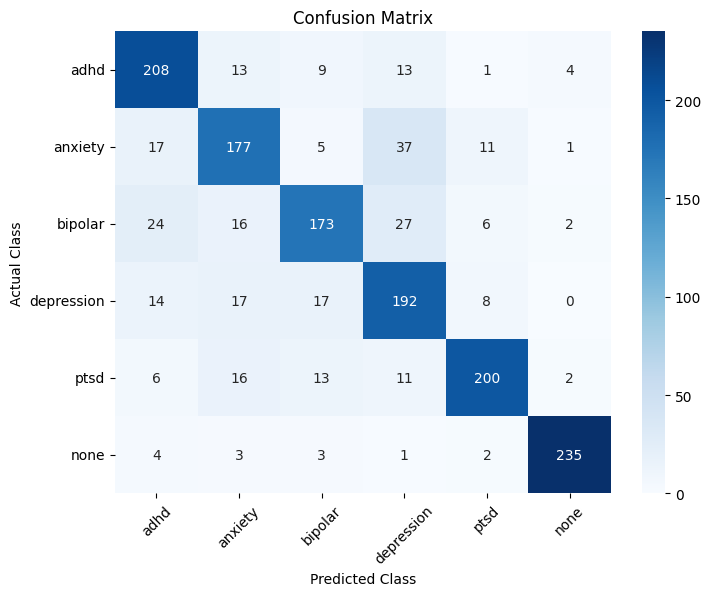

Accuracy: 0.7963709677419355
              precision    recall  f1-score   support

        adhd       0.76      0.84      0.80       248
     anxiety       0.73      0.71      0.72       248
     bipolar       0.79      0.70      0.74       248
  depression       0.68      0.77      0.73       248
        ptsd       0.88      0.81      0.84       248
        none       0.96      0.95      0.96       248

    accuracy                           0.80      1488
   macro avg       0.80      0.80      0.80      1488
weighted avg       0.80      0.80      0.80      1488



In [ ]:
from sklearn.metrics import confusion_matrix
print('\t Printing confusion matrix')
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(test_labels, y_pred_label)

# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(result, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(actuals_names)) + 0.5, labels=actuals_names, rotation=45)
plt.yticks(ticks=np.arange(len(predictions_names)) + 0.5, labels=predictions_names, rotation=0)

# Add labels, title, and color bar
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

print(f'Accuracy: {accuracy_score(test_labels, y_pred_label)}')

print(classification_report(test_labels, y_pred_label, target_names=predictions_names))

In [ ]:
print('\t Saving all mismatches')
# Plot the confusion matrix
actuals_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
predictions_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

mismatches = []
for i in range(len(test_labels)):
    if test_labels[i] != y_pred_label[i]:
        id1 = test_labels[i]
        id2 = y_pred_label[i]
        entry = {}
        entry['actual'] = actuals_names[id1]
        entry['predicted'] = predictions_names[id2]
        entry['test_id'] = i
        entry['text'] = test_examples[i]
        mismatches.append(entry)
df = pd.DataFrame(mismatches)
df.to_csv('drive/MyDrive/MIDS/w266/02_final_project/mids-w266-project/updated/mismatches_bert_posts.csv', index=False)


	 Saving all mismatches
